# Image classification
Using Kaggle digit dataset available on https://www.kaggle.com/c/digit-recognizer/overview.

In [81]:
from nnet import NeuralNetwork
from nnet.activations import Sigmoid, Identity, Relu, Softmax
from nnet.losses import BinomialLoss, QuadraticLoss, MultinomialLoss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
from tqdm.notebook import tqdm, trange

data = pd.read_csv("data/digit-recognizer/train.csv")
msk = np.random.rand(len(data)) < 0.8
data_train = data[msk]
data_test = data[~msk]

## Data processing

In [82]:
# Data preparation functions

def add_one_feature(x):
    """Transforimng input matrix to have a feature consisting of all ones."""
    assert len(x.shape) == 2
    n = x.shape[1]
    return np.vstack([x, np.ones([1, n])])

def one_hot_encode(labels, n_classes):
    m = len(labels)
    y_train = np.zeros((n_classes, m))
    y_train[labels, np.arange(m)] = 1
    return y_train

def one_hot_decode(y):
    return np.array([np.argmax(r) for r in y.T])

# Train test split

x_train = data_train.drop("label", axis=1).values.T
labels_train = data_train["label"].values
y_train = one_hot_encode(labels_train, n_classes=10)
print(x_train.shape, y_train.shape)

x_test = add_one_feature(data_test.drop("label", axis=1).values.T)
labels_test = data_test["label"].values
y_test = one_hot_encode(labels_test, n_classes=10)
print(x_test.shape, y_test.shape)

(784, 33627) (10, 33627)


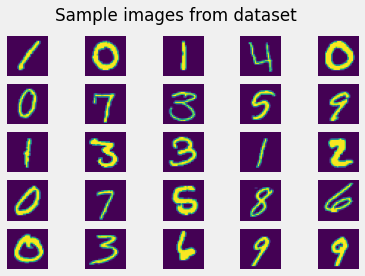

In [83]:
size = 5
fig, axes = plt.subplots(size, size)
for i in range(size):
    for j in range(size):
        axes[i][j].imshow(x_train[:, i*size + j].reshape(28, 28))
        axes[i][j].axis("off")
fig.suptitle("Sample images from dataset");

In [84]:
x_train = add_one_feature(x_train)
x_train.shape

(785, 33627)

## Training neural network

In [85]:
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

In [86]:
def train_generator(x, y, batch_size):
    """Inifnite generator over x with size of batches equal to batch_size"""
    i = 0
    p, m = x.shape
    assert x.shape[1] == y.shape[1]
    while True:
        yield x_train[:, i:i+batch_size], y_train[:, i:i+batch_size]
        i += batch_size
        if i >= m:
            i = 0

In [87]:
batch_size = 10_000
gen = train_generator(x_train, y_train, batch_size)

In [97]:
losses = []
test_accuracies = []
net = NeuralNetwork(785, [(128, Relu()), (16, Relu()), (10, Softmax())], MultinomialLoss(), sd=1e-2)
n_epochs = 100
m = x_train.shape[1]
n_iter = n_epochs * (m // batch_size)
for i in tqdm(range(n_iter)):
    x, y = next(gen)
    loss = net.fit(x, y, lr=0.01, n_iter=1, verbose=False)
    losses.append(loss)
    if i % 10 == 0:
        test_accuracies.append(accuracy(one_hot_decode(net(x_test)), labels_test))

In [98]:
y_pred_train = one_hot_decode(net(x_train))
print("Accuracy on train set:", accuracy(y_pred_train, labels_train))

Accuracy on train set: 0.9552145597287893


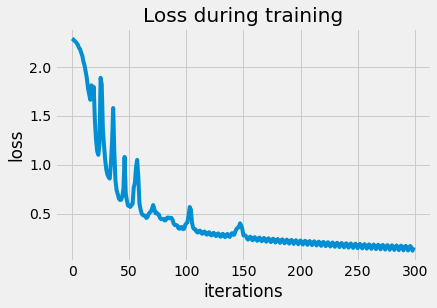

In [99]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Loss during training");

## Evaluation on test set

In [100]:
y_pred_test = one_hot_decode(net(x_test))
print("Accuracy on test set:", accuracy(y_pred_test, labels_test))

Accuracy on test set: 0.952934131736527


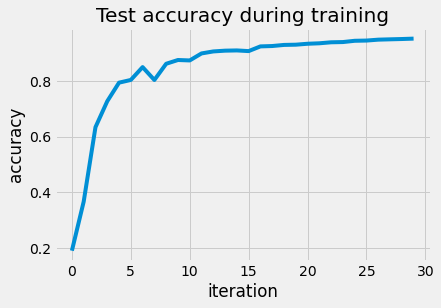

In [102]:
plt.plot(test_accuracies)
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("Test accuracy during training");

## Saving predictions

In [106]:
test = pd.read_csv("data/digit-recognizer/test.csv")
x_test = add_one_feature(test.values.T)
x_test.shape

(785, 28000)

In [127]:
y_pred = one_hot_decode(net(x_test))

In [129]:
df = pd.DataFrame({"Label": y_pred}).reset_index()
df.columns = ["ImageId", "Label"]
df["ImageId"] = df["ImageId"] + 1
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [130]:
df.to_csv("data/digit-recognizer/submission.csv", index=False)